## Table of Content:
1. Objective
2. Data manipulation:
  - Data Loading
  - Data Viewing
  - Data Cleaning
  - Data Slicing
  - Data Mapping
3. Recommendation models:
  - Recommendation with collaborative filtering
  - Recommendation with pearsons'R correlation



## Objective
Learn from data and recommended best TV shows to users, bases on self & others behavior.

## Data manipulation

### Data Loading
Each data file (**combined_data_[1-5].txt**) contains below columns:
- Movie ID (as first line of each new movie record / file)
- Customer ID
- Rating (1 to 5)
- Date they gave the ratings

The **movie_titles_v2.csv** file contains the mapping of Movie ID to the movie background like name, year of release, etc

In [2]:
# connect to drive to load data
import os
from google.colab import drive
drive.mount('/content/drive')

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cpu')

In [3]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162674 sha256=5572b652a5f82d0d54759e6bfb57457e923f3aae28d02c479e9c33606e0b3a73
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
# import libraries
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Next, loading first data file and explore how large the data

In [5]:
%cd /content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/
# Skip date
df1 = pd.read_csv('combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.head())

Dataset 1 shape: (22605786, 2)
-Dataset examples-
   Cust_Id  Rating
0    9211:     NaN
1  1277134     1.0
2  2435457     2.0
3  2338545     3.0
4  2218269     1.0


The first data huge enough to use free google colab notebook. So, we couldn't merge another dataset to a dataframe because the noterbook will not work.

In [6]:
# rename df1 to df
df = df1

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.head())

Full dataset shape: (22605786, 2)
-Dataset examples-
   Cust_Id  Rating
0    9211:     NaN
1  1277134     1.0
2  2435457     2.0
3  2338545     3.0
4  2218269     1.0


### Data viewing

Giving a first look on how the data spread:

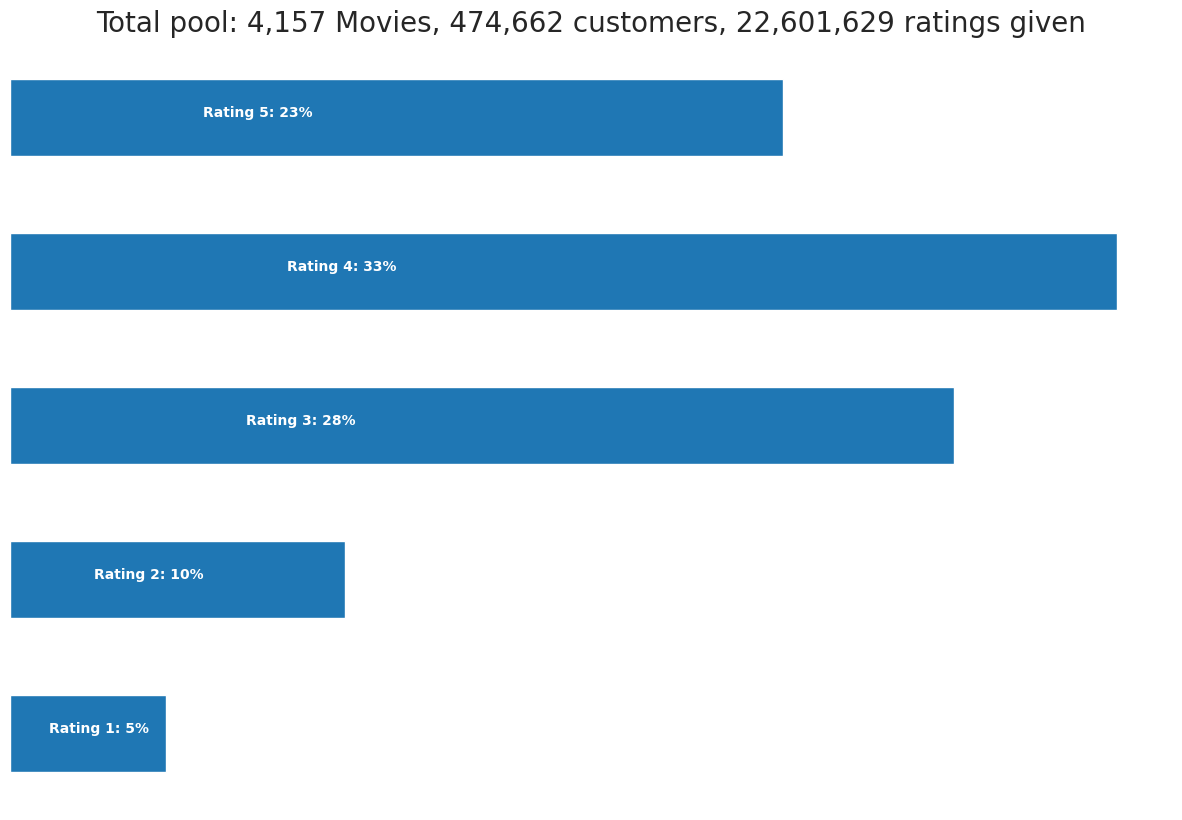

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

The generally positive ratings (>3) may be attributed to the likelihood that dissatisfied customers are more inclined to simply leave without providing feedback. It's essential to consider that low ratings for movies usually indicate their overall poor quality.

### Data cleaning

Movie ID makes the kernel run out of memory so I created an array with the correct length and then added the whole array as a column into the main data frame.
- A DataFrame named `df_nan` is created to identify null values in the 'Rating' column of the original DataFrame `df`.
- A loop iterates through the indices of null ratings in `df_nan`.
- For each pair of consecutive indices, it creates an array (`temp`) filled with the corresponding movie_id, representing a unique identifier for each movie. The arrays are appended to the `movie_np` list.

In [8]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length of movies: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.157e+03 4.157e+03 4.157e+03]
Length of movies: 22601629


In [9]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
df.head()

<ipython-input-9-ec94731a69f0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-


<ipython-input-9-ec94731a69f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


,Cust_Id,Rating,Movie_Id
1,1277134,1.0,1
2,2435457,2.0,1
3,2338545,3.0,1
4,2218269,1.0,1
5,441153,4.0,1


### Data Slicing

To enhance the efficiency and statistical significance of the analysis on a substantially large dataset, I aim to reduce its volume by implementing the following criteria:
- Exclude movies with a limited number of reviews, as they are considered relatively unpopular.
- Exclude customers who provide too few reviews, as they are perceived as less active.

By implementing these benchmarks, the overall dataset size will be effectively reduced. This approach is expected to improve computational efficiency, especially considering that less popular movies and inactive customers still occupy the same matrix space as their more popular and active counterparts (NaN values also occupy space). Additionally, this strategy is anticipated to enhance the statistical significance of the analysis.

In [10]:
f = ['count','mean']
df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
#df_movie_summary.to_csv('/content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/movie_summary.csv')

movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index #collaborative --> save df_movie_summary
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
#df_cust_summary.to_csv('/content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/cus_movi.csv')

cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1908.0
Customer minimum times of review: 48.0


Groups the df dataset by the 'Movie_Id' column. For each movie, it calculates two summary statistics: the count of reviews and the mean rating.

**Movie Benchmark Calculation**: *The variable **movie_benchmark** is set to the 70th percentile of the review count distribution (count column). Movies with review counts below this benchmark are considered relatively unpopular and will be excluded from the dataset.*

**Customer Review Summary**: *Similar to the movie summary, the dataset is grouped by the 'Cust_Id' column. It calculates the count of reviews and the mean rating for each customer.*

**Customer Benchmark Calculation**: *The variable **cust_benchmark** is set to the 70th percentile of the review count distribution for customers. Customers with review counts below this benchmark are considered less active and will be excluded from the dataset.*

**Displaying Benchmarks**: *The minimum review count benchmarks for movies and customers are displayed. These benchmarks help in filtering out movies and customers with lower review counts, aiming to improve efficiency and statistical significance in the subsequent steps of building the recommendation system. Movies and customers falling below the respective benchmarks will be excluded from the analysis.*

In [11]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])
#df.to_csv('/content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/cleaned_data.csv')

Original Shape: (22601629, 3)
After Trim Shape: (16008083, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
2561       306466     2.0         7
6964285   2555377     4.0      1397
14073380  1475279     3.0      2678
21130651   982635     4.0      3842


In [12]:
%cd /content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/
unique_movie_ids = df['Movie_Id'].unique()[:80]

# Lọc DataFrame để chỉ giữ lại các dòng có 'Movie_Id' nằm trong danh sách trên
df_filtered = df[df['Movie_Id'].isin(unique_movie_ids)]

# Lấy 100,000 dòng đầu tiên của DataFrame đã lọc
df_final = df_filtered.head(200000)

# Xáo trộn DataFrame
df_shuffled = df_final.sample(frac=1, random_state=67)

# Lấy ngẫu nhiên 100,000 dòng
df_sampled = df_shuffled.head(200000)

# Hiển thị DataFrame kết quả
print(df_sampled)
#df_sampled.to_csv('cleaned_data.csv')

/content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix
        Cust_Id  Rating  Movie_Id
50141    974911     2.0        22
73768    314790     3.0        24
206890   839086     5.0        44
88403   1003613     4.0        25
189464   829000     4.0        44
...         ...     ...       ...
207977   622850     4.0        44
222517   167759     5.0        44
169631  1080876     4.0        44
106818   839374     5.0        26
76643   1903627     3.0        24

[200000 rows x 3 columns]


In [13]:
movie_ids = df_sampled.Movie_Id.value_counts()
movie_ids.values

array([56842, 18156, 14320, 14249, 11910, 11897, 10962, 10024,  8171,
        8080,  7309,  6231,  3371,  2870,  2656,  2271,  2008,  1942,
        1795,  1709,  1662,  1565])

The pivot table is a fundamental structure for **collaborative filtering** in recommendation systems. It organizes the data in a way that makes it easier to analyze and generate recommendations based on user preferences. In this case, each row represents a customer, each column represents a movie, and the values represent the ratings given by customers to movies.

In [14]:
%cd /content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/
df = df_sampled.copy()
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)
#df_p.to_csv('df_pivot.csv')

(97672, 22)


### Data mapping

In [43]:
%cd /content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix/
df_title = pd.read_csv('movie_titles_v2.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5'], nrows=4155).iloc[:,:3]
df_title.set_index('Movie_Id', inplace = True)
df_title['image'] = df_title['Name'].str.lower()
characters_to_remove = [":", "'", "#", "/", "?", "!", "%", "$", "*", ".", "&"]
for char in characters_to_remove:
    df_title['image'] = df_title['image'].str.replace(char, "")

df_title['image'] = df_title['image'].str.replace(" ", "_")
df_title['image'] = df_title['image'].str.cat(['.jpg'] * len(df_title))
#df_title.to_csv('data_Netflix/movie_titles.csv')
movie_images = dict(zip(df_title['Name'], df_title['image']))
df_title.head(15)

/content/drive/MyDrive/Quỳnh_Như_with_AI/recommendation_system/data_Netflix


<ipython-input-43-878d35a63f13>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_title['image'] = df_title['image'].str.replace(char, "")


,Year,Name,image
Movie_Id,,,
1,2003,Dinosaur Planet,dinosaur_planet.jpg
2,2004,Isle of Man TT 2004 Review,isle_of_man_tt_2004_review.jpg
3,1997,Character,character.jpg
4,1994,Paula Abdul's Get Up & Dance,paula_abduls_get_up__dance.jpg
5,2004,The Rise and Fall of ECW,the_rise_and_fall_of_ecw.jpg
6,1997,Sick,sick.jpg
7,1992,8 Man,8_man.jpg
8,2004,What the #$*! Do We Know!?,what_the__do_we_know.jpg
9,1991,Class of Nuke 'Em High 2,class_of_nuke_em_high_2.jpg


## Recommendation models

### Recommend with Collaborative Filtering

In [20]:
reader = Reader()

# get just top 1M rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']].iloc[:1000000], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])
trainset = data.build_full_trainset()
svd.fit(trainset)
print('Model complete!!')

Model complete!!


what user 2485184 liked?

In [21]:
df_2485184 = df[(df['Cust_Id'] == 2485184) & (df['Rating'] >= 4)]
df_2485184 = df_2485184.set_index('Movie_Id')
df_2485184 = df_2485184.join(df_title)['Name']
print(df_2485184)

Series([], Name: Name, dtype: object)


predict which movies user 2485184 would love to watch:

In [22]:
def predict_movies_for_user(user_id, df_title, drop_movie_list, svd, top_n=12):
    user = df_title.copy().reset_index()
    user = user[~user['Movie_Id'].isin(drop_movie_list)]
    user['Estimate_Score'] = user['Movie_Id'].apply(lambda x: svd.predict(user_id, x).est)
    user = user.drop('Movie_Id', axis=1)

    user = user.sort_values('Estimate_Score', ascending=False)
    user['Estimate_Score'] = round(user['Estimate_Score'], 2)
    recommended_movies = user.head(top_n)

    return recommended_movies

predict_movies_for_user(2485184, df_title, drop_movie_list, svd)

,Year,Name,Estimate_Score
0,2004.0,Sarah Brightman Special: Harem: A Desert Fantasy,3.54
1,1954.0,Beat the Devil,3.54
3,1978.0,MASH: Season 7,3.54
4,2001.0,REO Speedwagon: Live Plus,3.54
5,2005.0,Hercules,3.54
10,2002.0,Frailty,3.54
11,1999.0,Mystery Science Theater 3000: Merlin's Shop of...,3.54
12,1997.0,Highlander: Season 6,3.54
13,1995.0,Boys on the Side,3.54
14,1987.0,Hello Again,3.54


### Recommend with Pearsons' correlations

The way it works is we use Pearsons' correlation to measure the linear correlation between review scores of all pairs of movies, then we provide the top 20 movies with highest correlations

In [60]:
### Recommend with Pearsons' correlations ## df_title, df_p, df_movie_summary
def recommend(movie_title):
    print("For movie ({})".format(movie_title))
    if len(df_title['Name'].str.lower() == movie_title.lower()) != 0:
      print("- Top 20 movies recommended based on Pearsons' correlation - ")
      i = int(df_title.index[df_title['Name'].str.lower() == movie_title.lower()][0])
      target = df_p[i]
      similar_to_target = df_p.corrwith(target)
      corr_target = pd.DataFrame(similar_to_target, columns = ['Estimate_Score'])
      corr_target.dropna(inplace = True)
      corr_target = corr_target.sort_values('Estimate_Score', ascending = False)
      corr_target['Estimate_Score'] = round(corr_target['Estimate_Score'], 2)
      #corr_target = corr_target.drop('Cust_Id')
      corr_target.index = corr_target.index.map(int)
      corr_target = corr_target.join(df_title).join(df_movie_summary)[['Year', 'Name', 'Estimate_Score']]
      return corr_target[:10]#.to_string(index=False)
    else:
      return f"We can't the {movie_title} film!!! SORRY!!"

In [61]:
movie_title = '8 Man'
recommend(movie_title)

For movie (8 Man)
- Top 20 movies recommended based on Pearsons' correlation - 


,Year,Name,Estimate_Score
Movie_Id,,,
7,1992,8 Man,1.00
52,2002,The Weather Underground,0.44
19,2000,By Dawn's Early Light,0.37
13,2003,Lord of the Rings: The Return of the King: Ext...,0.32
27,1962,Sesame Street: Elmo's World: The Street We Liv...,0.32
26,2004,Never Die Alone,0.31
44,1996,Spitfire Grill,0.30
55,1995,Jade,0.30
24,1981,My Bloody Valentine,0.30


In [62]:
recommend("What the #$*! Do We Know!?")

For movie (What the #$*! Do We Know!?)
- Top 20 movies recommended based on Pearsons' correlation - 


,Year,Name,Estimate_Score
Movie_Id,,,
8,2004,What the #$*! Do We Know!?,1.00
50,1941,A Yank in the R.A.F.,0.53
47,1952,The Bad and the Beautiful,0.46
28,2002,Lilo and Stitch,0.44
13,2003,Lord of the Rings: The Return of the King: Ext...,0.42
55,1995,Jade,0.39
52,2002,The Weather Underground,0.38
27,1962,Sesame Street: Elmo's World: The Street We Liv...,0.37
26,2004,Never Die Alone,0.35
